In [1]:
# import pyforest
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import pickle
import warnings
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
# !pip install scikit-learn==1.2.2

In [3]:
print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
# numpy: 1.23.1
# sklearn: 1.3.2

numpy: 1.23.1


<IPython.core.display.Javascript object>

sklearn: 1.3.2


In [4]:
def get_tree_probabilities(model, x_data): 
    test_proba0_df = pd.DataFrame()
    test_proba1_df = pd.DataFrame()
    for tree_num in np.arange(len(model.estimators_)):
        test_proba_temp = model.estimators_[tree_num].predict_proba(x_data)
        # print(f'tree_num: {tree_num}, test_proba_temp shape: {test_proba_temp.shape}')
        test_proba0_df[tree_num] = test_proba_temp[:,0]
        test_proba1_df[tree_num] = test_proba_temp[:,1]
        # print(f'test_proba0_df shape: {test_proba0_df.shape}, test_proba1_df shape: {test_proba1_df.shape}')
    std0 = test_proba0_df.std(axis=1)
    std1 = test_proba1_df.std(axis=1)

    # print(f'in df tree prob function. std0 shape: {std0.shape}, std1 shape: {std1.shape}')
    return std0, std1

In [5]:
import scipy as sp
from sklearn.metrics import pairwise_distances

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis-train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [6]:
nanobret_RF='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/RF2?/'
nanobret_GP='/Users/jayceepang/msse/ATOM_CODE/examples/holdout/holdout_results/jp_holdout_summer2025/GP/'
datapath='/Users/jayceepang/msse/ATOM_CODE/datasets/holdout_data/featurized/'
neks = ['NEK2_binding','NEK2_inhibition','NEK3_binding','NEK5_binding','NEK9_binding','NEK9_inhibition']
og_datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
samplings =['none_scaled','UNDER','SMOTE'] 
RF_types = ['RF','RF_BCW','BRFC','BRFC_BCW']
model_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
remove_cols = ['NEK', 'compound_id', 'base_rdkit_smiles', 'active', 'subset'] 

In [7]:
def get_plotting_data_RF_UQ2(model, train_df, test_df): 
    test_dist = calc_AD_kmean_dist(train_df, test_df, k=7)
    train_dist = calc_AD_kmean_dist(train_df, train_df, k=7)
    std0, std1=get_tree_probabilities(model, test_df)
    return train_dist, test_dist, std0, std1
 

In [8]:
# pred_markers = {'TP': 'o','TN': 's', 'FP': '^', 'FN': 'D'}
pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}
sampling_combos = [('none_scaled','RF'),('none_scaled','RF_BCW'),('SMOTE','RF'), 
    ('none_scaled','BRFC'),('none_scaled','BRFC_BCW'),('UNDER','RF')]
# name_strat_lookup={'none_scaled': 'no_samp', 'RF': 'RF', 'RF_BCW': 'RF_BalWeight', 'BRFC': 'Bstrp Under', 'BRFC_BCW':'Bstrp Under BalWeight',
#                   'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}
name_strat_lookup={'none_scaled': 'Orig', 'RF': 'RF', 'RF_BCW': 'RF BalWeight', 'BRFC': 'Bstrp Under RF', 'BRFC_BCW':'Bstrp Under RF BalWeight',
                  'ADASYN': 'ADASYN', 'SMOTE':'SMOTE', 'UNDER':'UNDER'}

In [12]:
for nek in neks: 
    short_nek = nek[:4] 
    test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    
    # display(test_df)
    for samp in samplings: 
        for rf in RF_types: 
            # print(f'{nek} MFP {samp} {rf}')
            root_name = f'{nek}_MFP_{samp}'
         
            og_df = pd.read_csv(f'{og_datapath}{nek}_MFP_{samp}.csv') 
            train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)

            results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
            
            with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
                model = pickle.load(f) 

                # tree = model.estimators_[0]
                # print(tree.__dict__.keys())
            # train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ2(model, train_df, test_df)

            

In [19]:
def RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax):
    predictions = df['prediction']
    ad_dist=df['ADdist']
    true_pos = np.where((predictions == 1) & (true_labels == 1).flatten())[0] 
    true_neg = np.where((predictions == 0) & (true_labels == 0).flatten())[0]
    false_pos = np.where((predictions == 1) & (true_labels == 0).flatten())[0] 
    false_neg = np.where((predictions == 0) & (true_labels == 1).flatten())[0] 
    tp_std1 = std1[true_pos]
    tn_std0 = std0[true_neg]
    fp_std1 = std1[false_pos]
    fn_std1 = std1[false_neg]
    fn_std0 = std0[false_neg] # NEW MAR 29 2025
    tp_ad = ad_dist[true_pos]
    tn_ad = ad_dist[true_neg]
    fp_ad = ad_dist[false_pos]
    fn_ad = ad_dist[false_neg]

    data = {'std of probabilities': np.concatenate([tp_std1,tn_std0,fp_std1, fn_std0]),
        'prediction_type': ['TP'] * len(true_pos) + ['TN'] * len(true_neg) + ['FP'] * len(false_pos) + ['FN'] * len(false_neg),
        'ADdist': np.concatenate([tp_ad, tn_ad, fp_ad,fn_ad])}
    data = pd.DataFrame(data)
    sizes = data['prediction_type'].map(pred_sizes)
    # 
    sns.scatterplot(data=data, x='ADdist', y='std of probabilities', hue='prediction_type', palette=pred_palette,
           markers=pred_markers,style='prediction_type',ax=ax,s=120,alpha=0.75)
    ax.set_title(title, fontsize=19)
    ax.get_legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, .99),fontsize=16)
    ax.set_xlabel('ADdist', fontsize=16)
    # ax.set_ylabel('SD of probability', fontsize=15)
    ax.set_ylabel('')
    ax.set_ylim(-0.01, 0.51)
    # ax.set_xlim(-.30,12) 
    ax.set_xlim(-.30,9) 

In [17]:
def change_names(df): 
    df['strategy']=df['strategy'].replace('none_scaled', 'no_samp') 
    df['RF_type']=df['RF_type'].replace('BRFC', 'Bstrp Under RF') 
    df['RF_type']=df['RF_type'].replace('BRFC_BCW', 'Bstrp Under RF + BalWeight') 
    df['RF_type'] = df['RF_type'].replace('RF_BCW','RF_BalWeight')
    return df
    

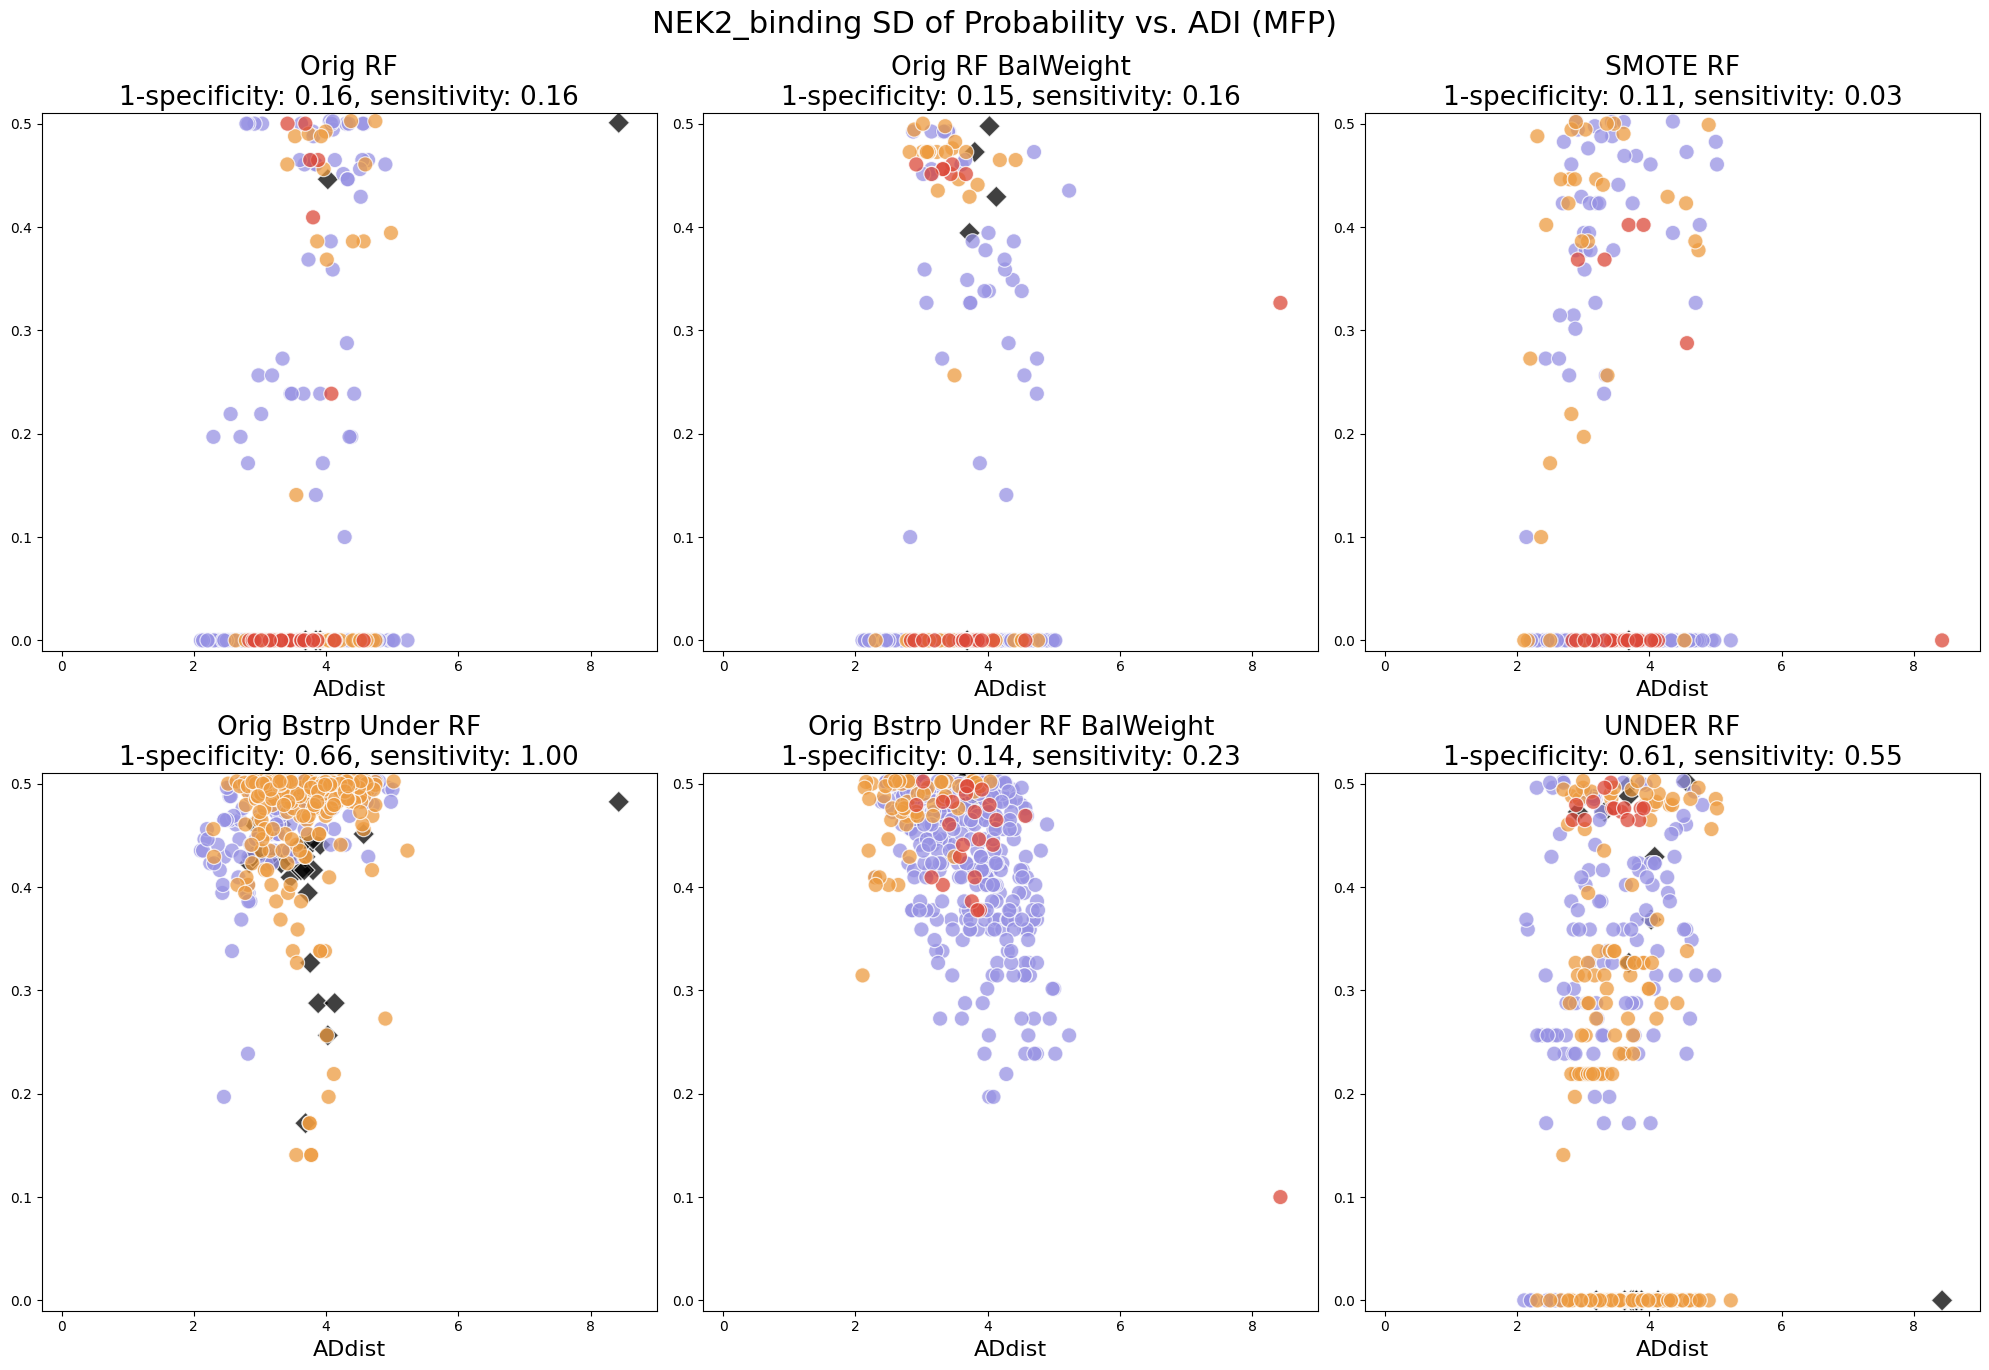

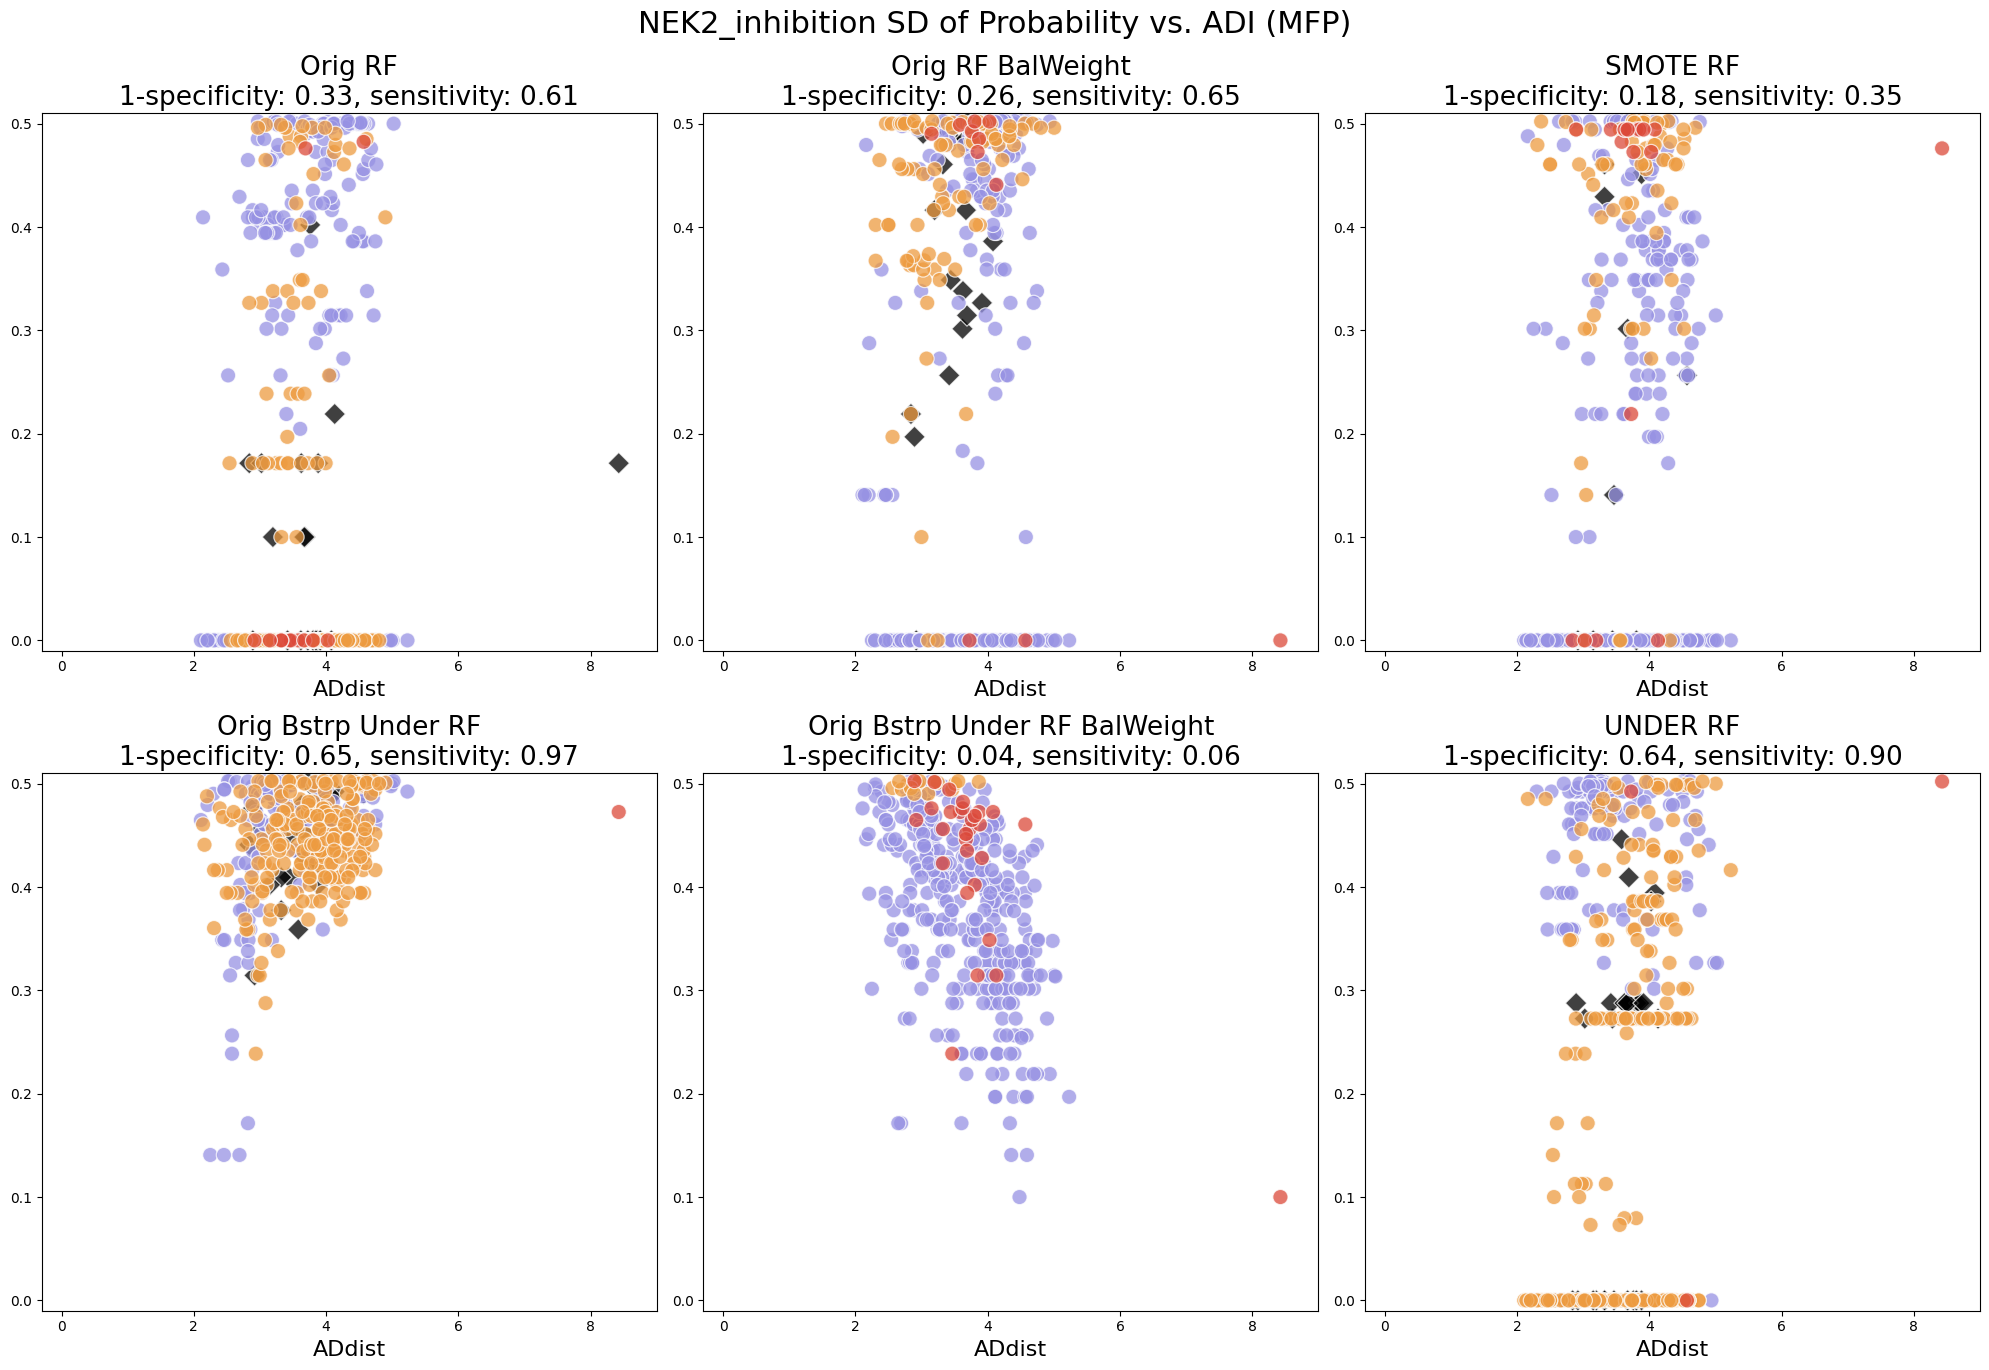

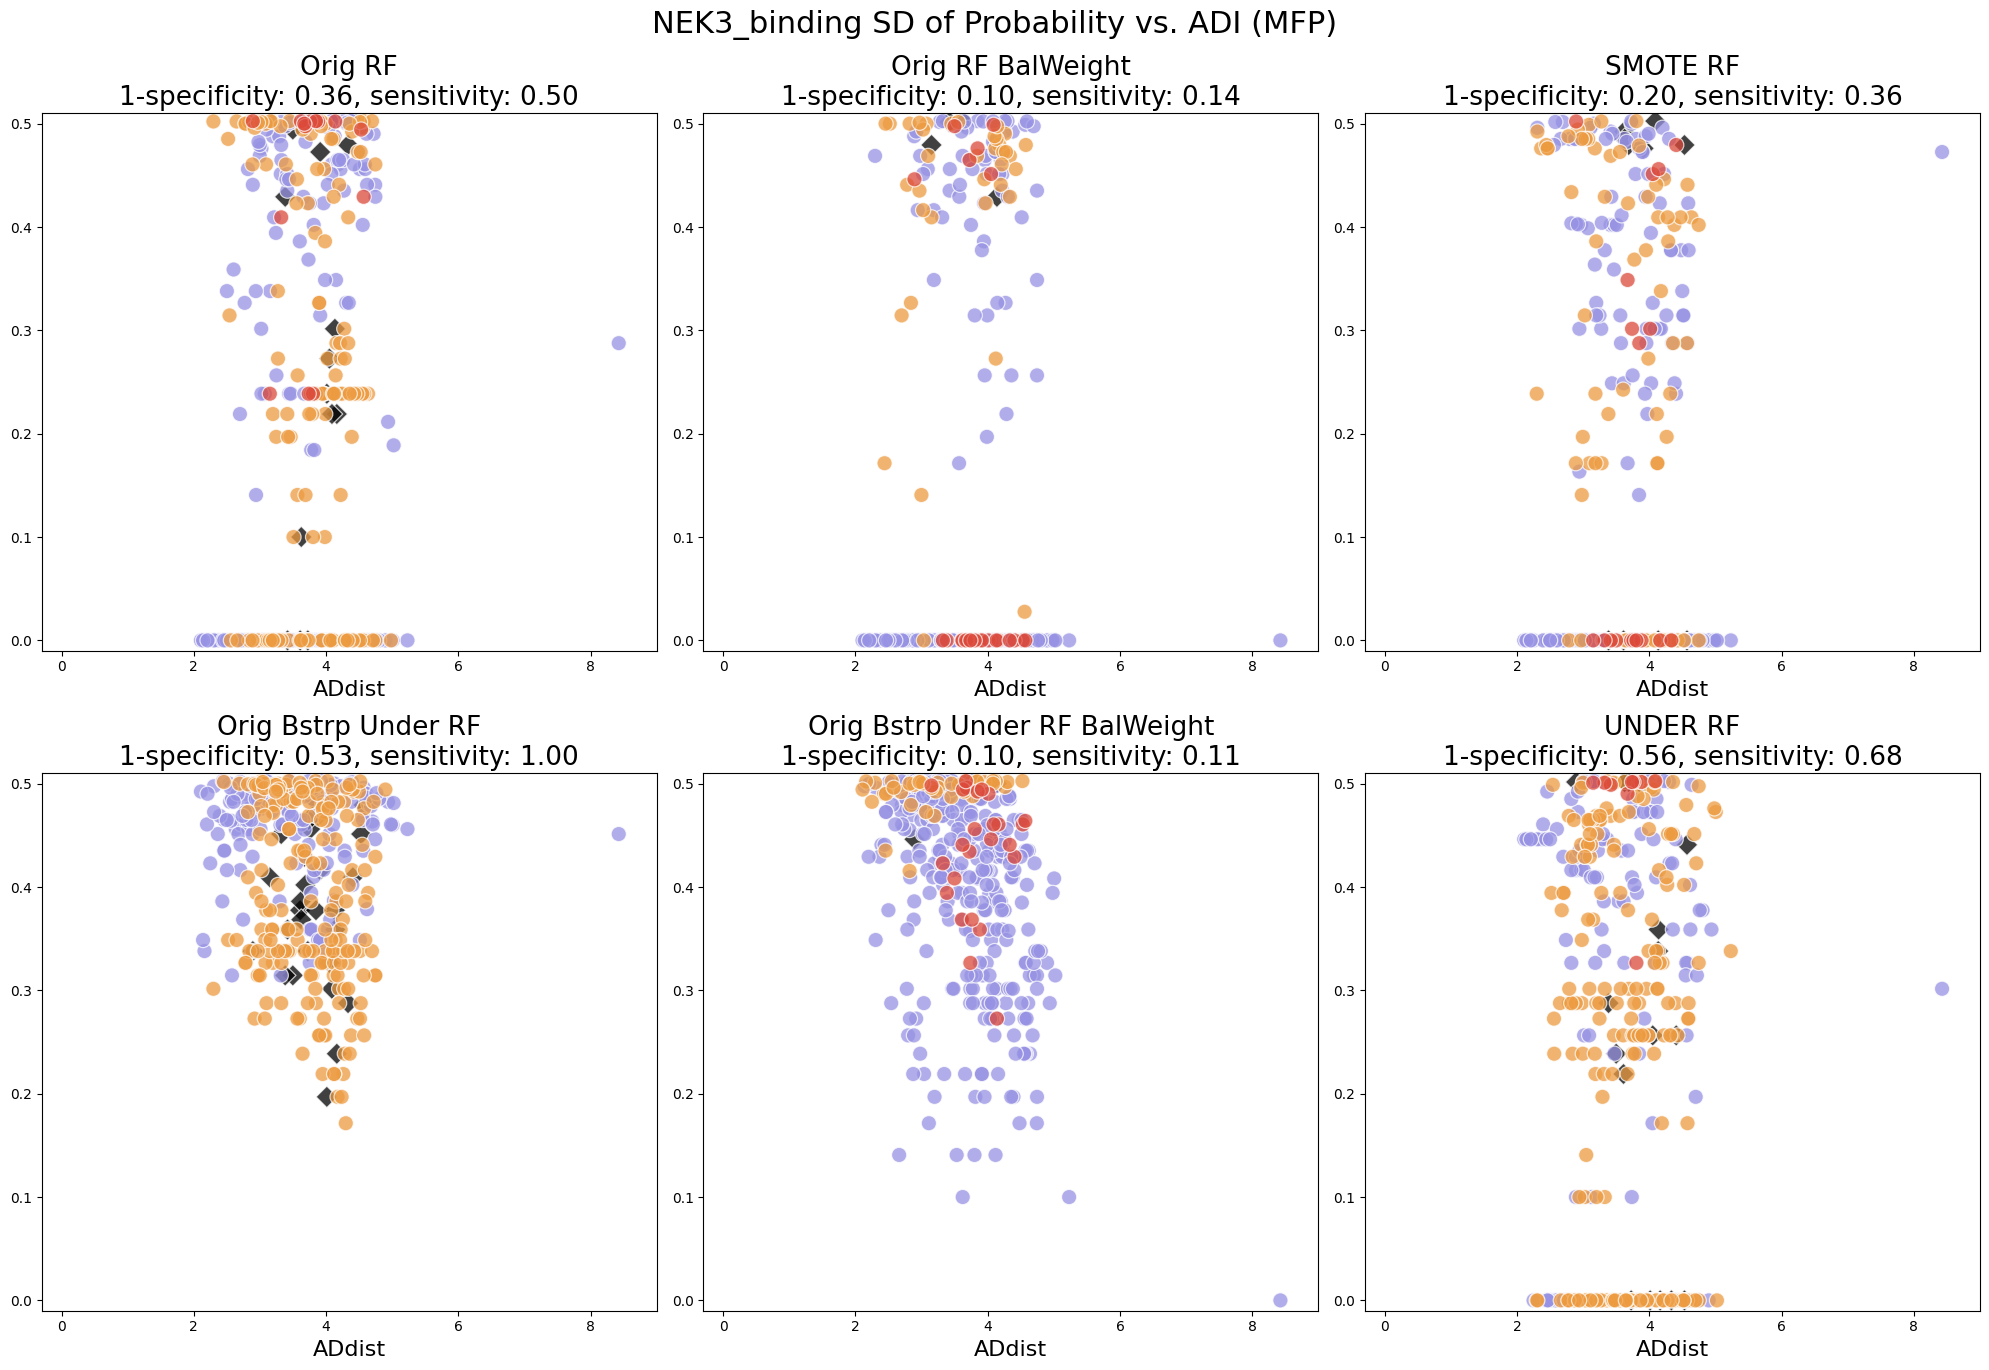

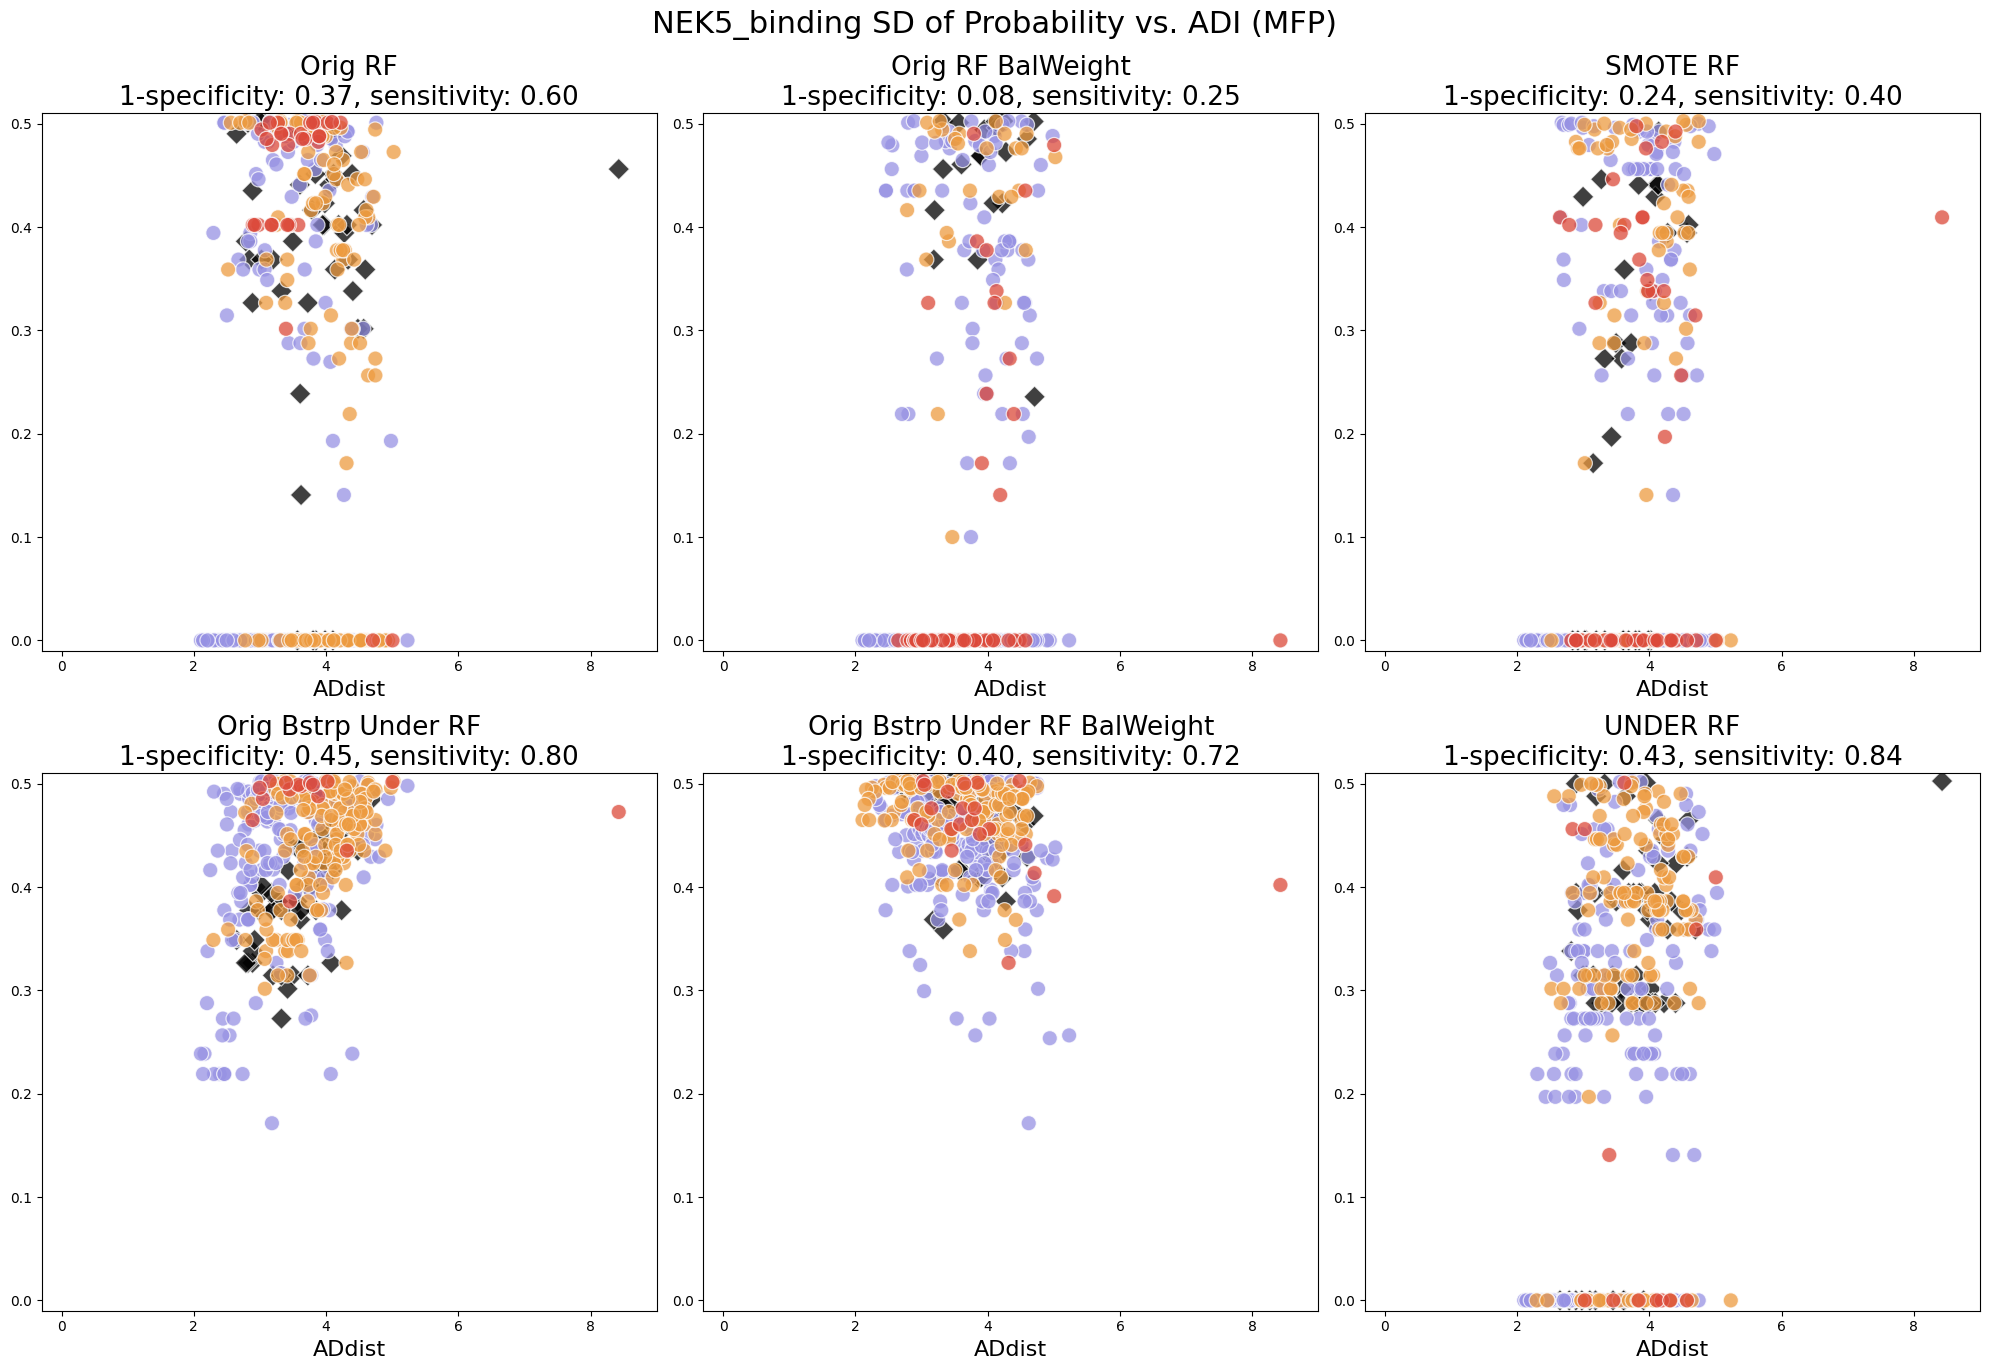

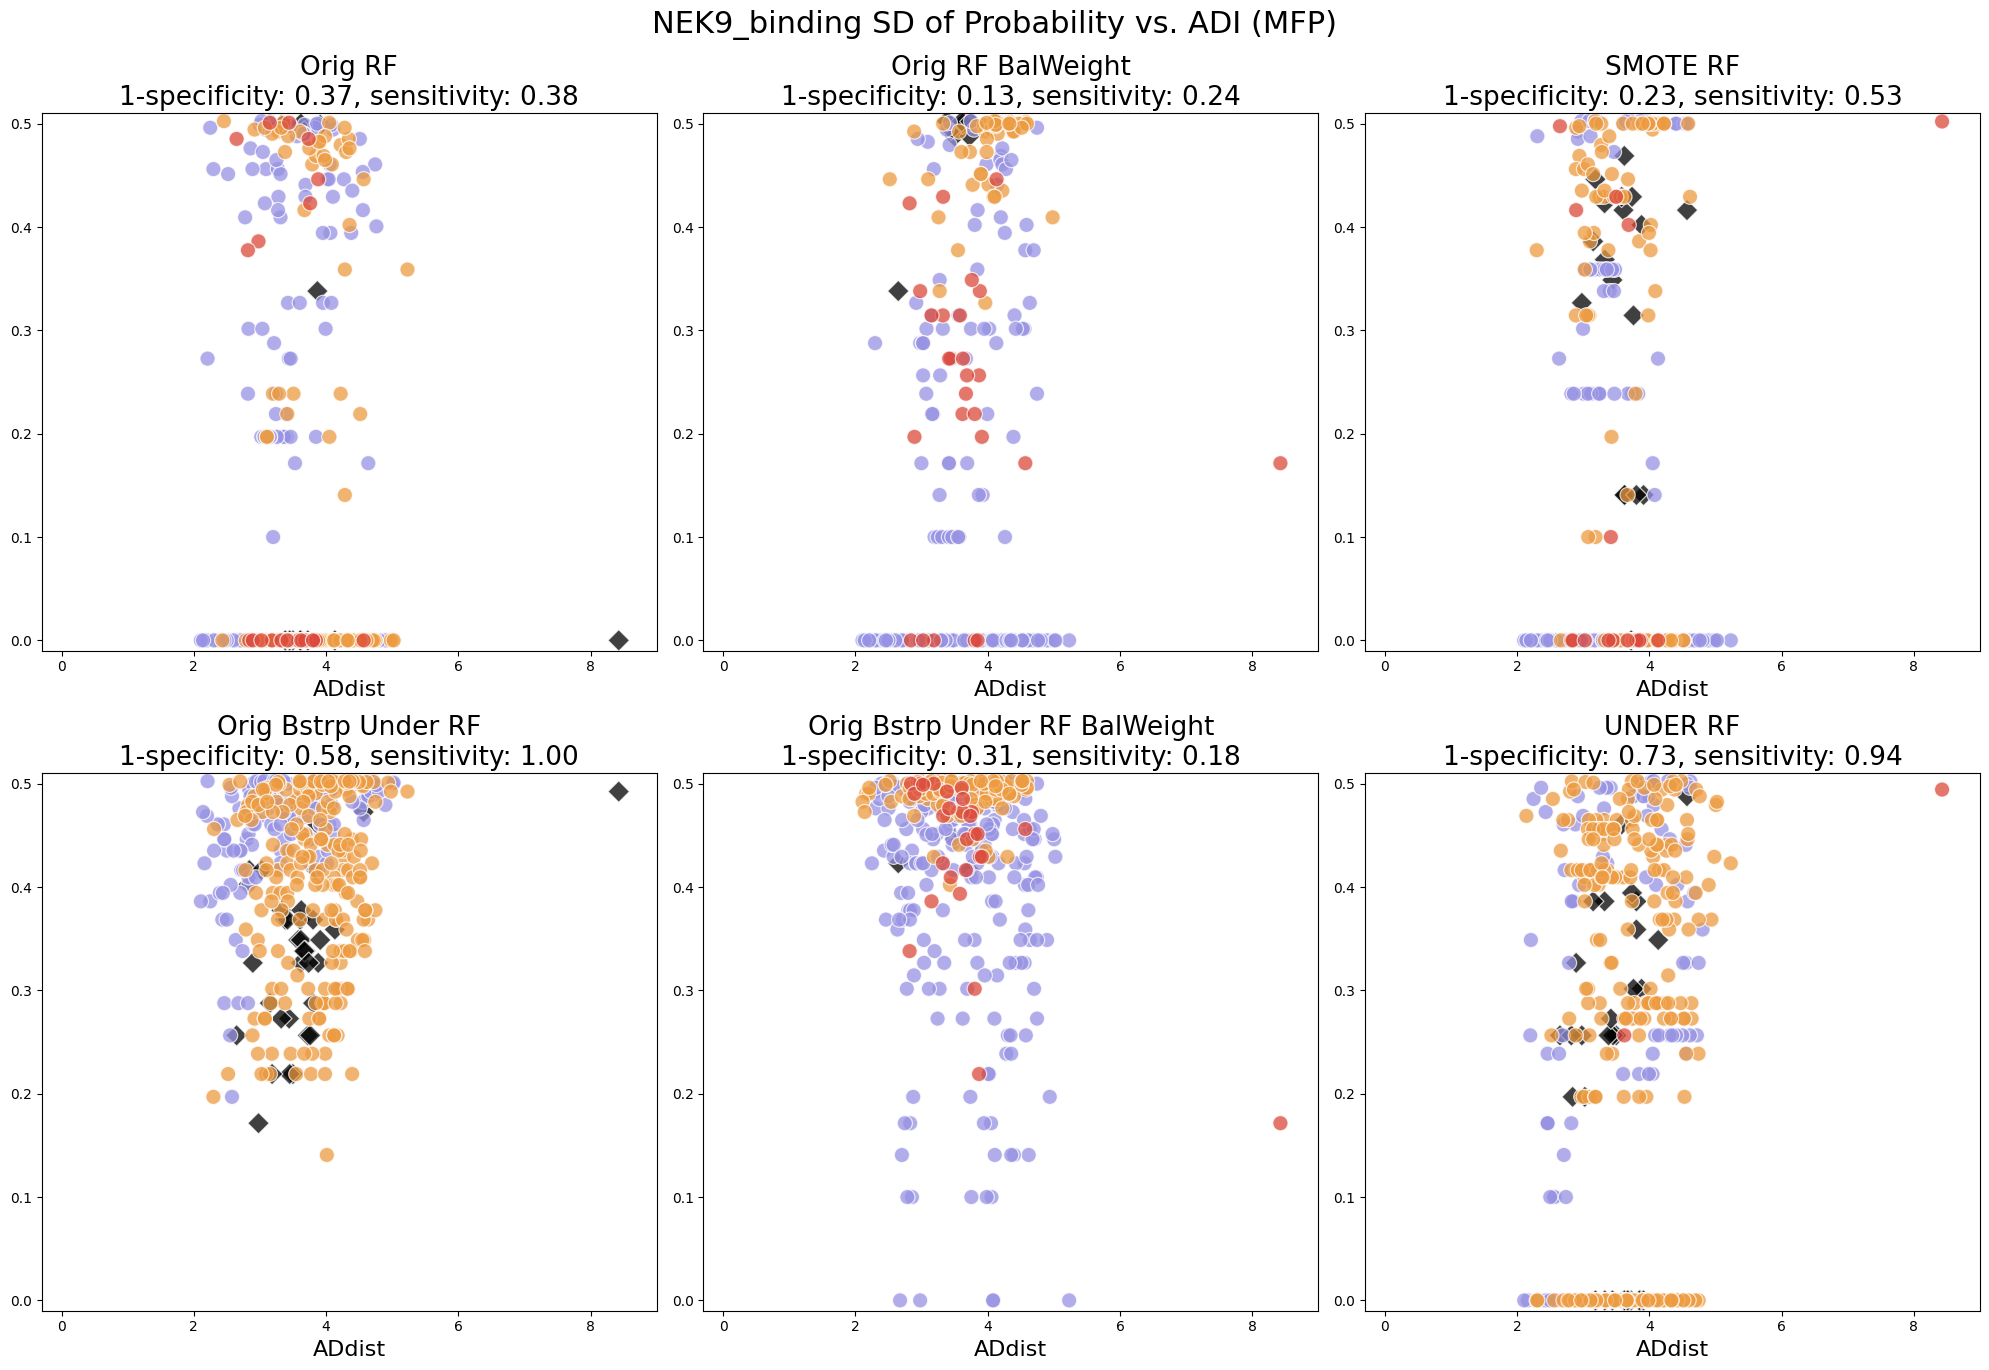

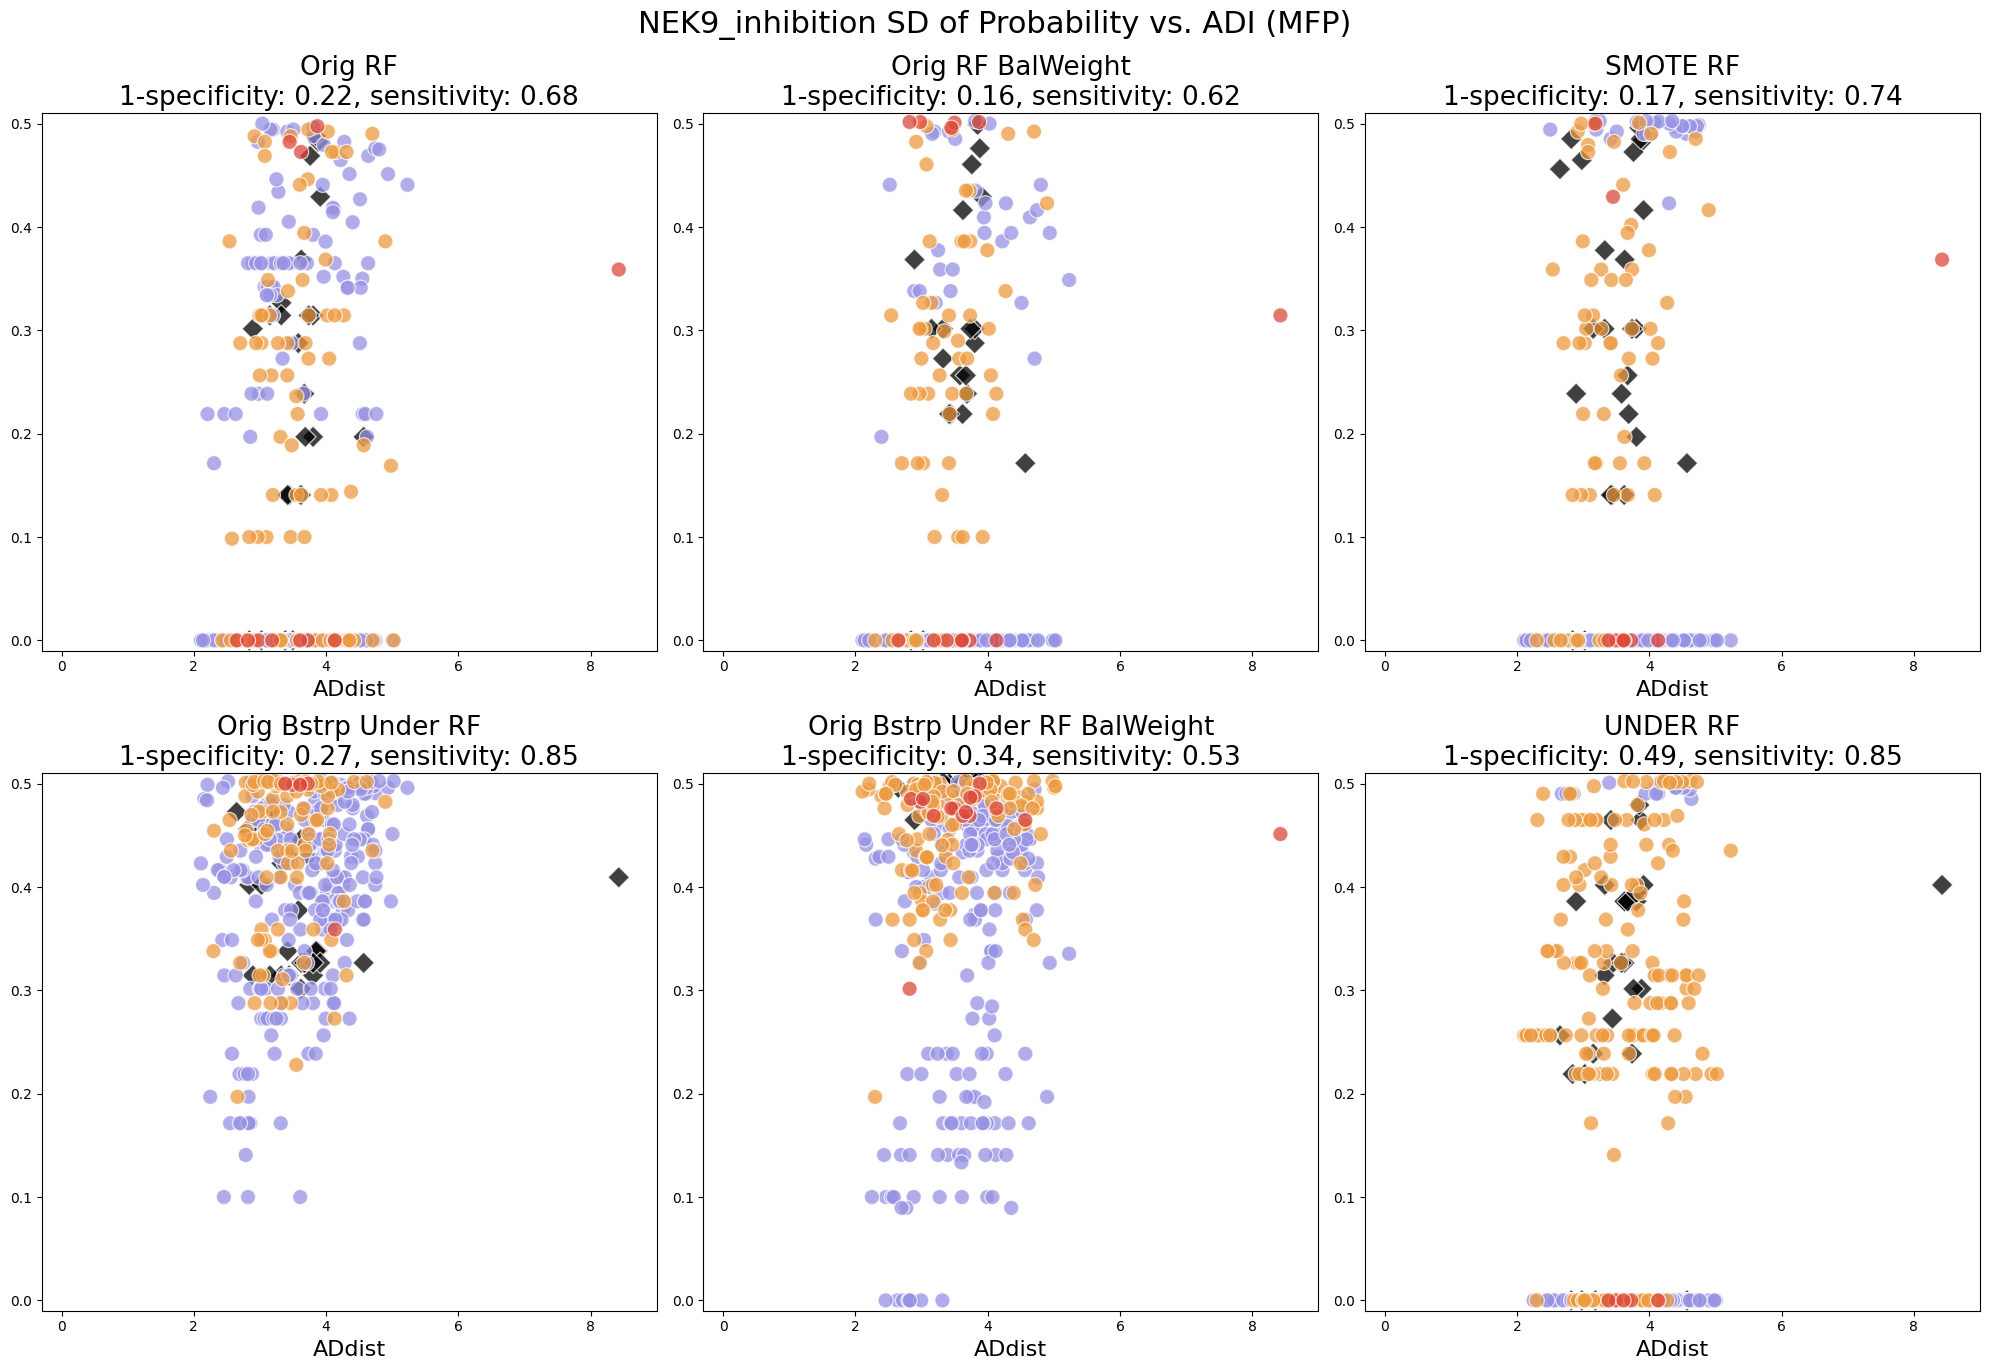

In [20]:
figure_path5=''
for nek in neks:
    short_nek = nek[:4] 
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
    fig.suptitle(f'{nek} SD of Probability vs. ADI (MFP)', fontsize=22,y=0.94)
    plt.subplots_adjust(hspace=0)
    count=0
    test_df = pd.read_csv(f'{datapath}{short_nek}_MFP_none_unscaled.csv').drop(columns=remove_cols)
    for count, (samp,rf) in enumerate(sampling_combos):
        row = count//3
        col = count%3
        ax =axes[row,col]
        count += 1
        root_name = f'{nek}_MFP_{samp}'
        results_df = pd.read_csv(f'{nanobret_RF}{short_nek}_{nek}_MFP_{samp}_{rf}_holdout_test.csv')
        train_df = og_df[og_df['subset'] == 'train'].drop(columns=remove_cols)
        with open(f'{model_path}{root_name}_{rf}_prod.pkl', 'rb') as f: 
            model = pickle.load(f) 
        train_dist, test_dist, std0, std1=get_plotting_data_RF_UQ2(model, train_df, test_df)
        results_df['1-specificity'] = 1-results_df['specificity'] 
        true_labels =results_df['y'].to_numpy()
        results_df=change_names(results_df)

        df = pd.DataFrame({'prediction': results_df['prediction'],'std0': std0,'std1': std1,'ADdist': test_dist,
            'feat_type': results_df['feat_type'], 'sensitivity':results_df['recall'], '1-specificity': results_df['1-specificity']})
        samp_label=f'{name_strat_lookup[samp]} {name_strat_lookup[rf]}'
        title = f'{samp_label}\n1-specificity: {results_df["1-specificity"].iloc[0]:.2f}, sensitivity: {results_df["recall"].iloc[0]:.2f}'
        RF_scatter_stdprob_AD_sbuplots(df, true_labels, title, ax)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    fig.savefig(f'RF_figs/{short_nek}_{nek}_MFP_nanobret_RF_UQ_scatter.png', bbox_inches='tight')

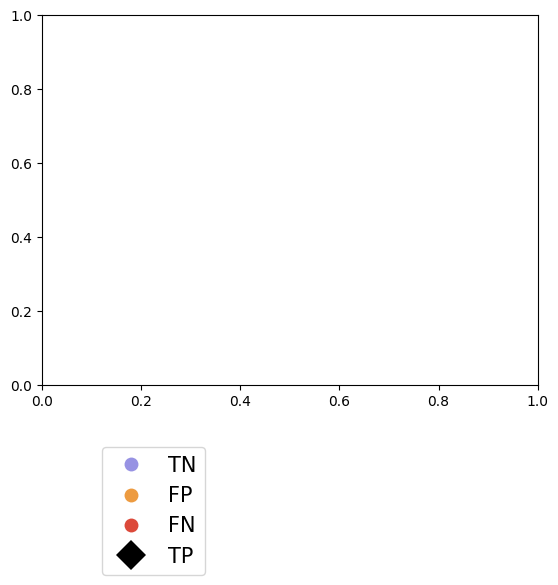

In [21]:
from matplotlib.lines import Line2D    
fig, ax=plt.subplots()

pred_markers = {'TP': 'D','TN': 'o', 'FP': 'o', 'FN': 'o'}
pred_sizes = {'TP': 150, 'TN': 95, 'FP': 97, 'FN': 97}
pred_palette = {'TP':'black', 'TN':'#9792E3', 'FP':'#ED9B40', 'FN':'#DC493A'}

truepos = Line2D([0],[0], marker='D', linestyle='None',markersize=15, markerfacecolor='black', markeredgewidth=0, label='TP')
falsepos = Line2D([0],[0], marker='o', linestyle='None',markersize=10, markerfacecolor='#ED9B40', markeredgewidth=0, label='FP')
trueneg= Line2D([0], [0], marker='o', linestyle='None', markersize=10, markerfacecolor='#9792E3', markeredgewidth=0, label='TN')
falseneg = Line2D([0], [0],  marker='o', linestyle='None', markersize=10, markerfacecolor='#DC493A', markeredgewidth=0, label='FN')

ax.legend(handles=[trueneg, falsepos, falseneg, truepos], ncols=1, bbox_to_anchor=(.35, -.14),fontsize=15)


In [23]:
samp_palette={'no_samp': 'tab:blue','UNDER': 'tab:orange','SMOTE': 'hotpink','ADASYN': 'tab:red',
 'no_sampling_RF': 'cornflowerblue','no_sampling_RF_BCW': 'lavender','UNDER_RF': 'orange','no_sampling_BRFC': 'blue',
 'SMOTE_RF': 'hotpink','ADASYN_RF': 'red','no_samp_BRFC_BCW': 'black',
 'no_sampling_BRFC_BCW': 'black','no_sampling_GP_RBF': 'cornflowerblue',
 'UNDER_GP_RBF': 'orange','SMOTE_GP_RBF': 'hotpink','ADASYN_GP_RBF': 'red','no_sampling_GP_matern': 'cornflowerblue',
 'UNDER_GP_matern': 'orange','SMOTE_GP_matern': 'hotpink','ADASYN_GP_matern': 'red',
 'no_samp_Bstrp Under':'blue', 'no_samp_RF':'cornflowerblue', 
    'no_samp_Bstrp Under BalWeight':'black', 'no_samp_RF_BalWeight':'lavender'}